# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "enrique"
ln1 = "gomez"
fn2 = "thihaiyen"
ln2 = "vu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_gomez_enrique_and_vu_thihaiyen.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]

        w[j] += 1./ lips_const[j] * A[:,j].dot(residuals)
        # update residuals:
        residuals += ( A[:,j].dot(old_w_j) - A[:,j].dot(w[j]) )
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.sum(A * A, axis=0)
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= 1./ lips_const[j] * gradient[j]
        # update gradient:
        gradient -= ( gram[:,j] * (old_w_j - w[j]) )
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- from a practical point of view, could you use greedy CD for ridge logistic regression? to solve OLS, but with 100,000 features? Explain your answers.

#### Compute a minimiser using linalg.solve

In [6]:
from scipy import linalg
%time w_solve = linalg.solve(np.dot(A.T, A), np.dot(A.T, b))

obj_solve = 0.5 * np.linalg.norm(A.dot(w_solve) - b) ** 2
print(obj_solve)

CPU times: user 2.9 ms, sys: 1.66 ms, total: 4.56 ms
Wall time: 5.27 ms
466.3849765337659


#### Performances of the two coordinate methods

In [7]:
print("========Cyclic Coordinate Descent========")
%time w_cyclic,objs_cyclic = cyclic_cd(A,b,10000)
print(objs_cyclic[-1])

========Cyclic Coordinate Descent========
CPU times: user 239 ms, sys: 16.7 ms, total: 255 ms
Wall time: 157 ms
466.384976533766


In [8]:
print("========Greedy Coordinate Descent========")
%time w_greedy,objs_greedy = greedy_cd(A,b,10000)
print(objs_greedy[-1])

========Greedy Coordinate Descent========
CPU times: user 181 ms, sys: 18.7 ms, total: 200 ms
Wall time: 109 ms
466.3849765337658


### Coments 

We see that the two methods succeed to obtain the true minimum of the problem. The cyclic coordinate descent takes more time than greedy coordinate descent in this case.

Text(0.5, 1.0, 'Comparision of objective function error - CCD and GCD')

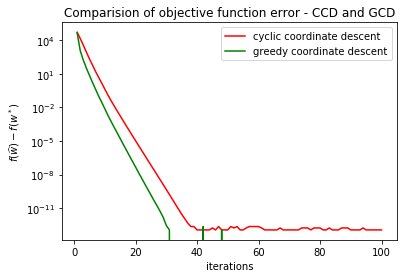

In [9]:
iter_range = np.arange(objs_cyclic.shape[0])+1
plt.semilogy(iter_range, objs_cyclic - obj_solve, color='r', label='cyclic coordinate descent')
plt.semilogy(iter_range, objs_greedy - obj_solve, color='g', label='greedy coordinate descent')
plt.legend()
plt.ylabel('$f(\widehat{w}) - f(w^*)$')
plt.xlabel('iterations')
plt.title('Comparision of objective function error - CCD and GCD')

### Coments 

We observe that the greedy coordinate descent is faster than the cyclic coordinate descent.

##### For logistic regression,
the gradient is written as the sum of functions of $\exp(-b_i a_i^\top w)$. Therefore, we cannot update the gradient for each coordinate update with a constant cost as in the least square lost, which makes the greedy coordinate descent much more costly than cyclic coordinate descent or gradient descent. So the use of greedy CD is not pratical in this case. 

##### For OLS with many features

In [10]:
n_features = 1000
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=100, for_logreg=False)

In [11]:
print("========Cyclic Coordinate Descent========")
%time w_cyclic,objs_cyclic = cyclic_cd(A,b,10000)
print(objs_cyclic[-1])

========Cyclic Coordinate Descent========
CPU times: user 136 ms, sys: 14.3 ms, total: 150 ms
Wall time: 89.4 ms
1.0155766052493663e-23


In [12]:
print("========Greedy Coordinate Descent========")
%time w_greedy,objs_greedy = greedy_cd(A,b,10000)
print(objs_greedy[-1])

========Greedy Coordinate Descent========
CPU times: user 364 ms, sys: 29.8 ms, total: 394 ms
Wall time: 220 ms
3.134275031530507e-26


We observe that in this case the greedy CD is slower than cyclic GD.

In general, we see that, for each iteration, the step finding $j$ that maximizes the gradient takes $O(p)$ cost, hence for $p$ updates it takes $O(p^2 + pn)$ cost, compared to $O(pn)$ of cyclic GD or GD. By consequence, for $p \gg n$, greedy CD is more costly than cyclic CD, hence it is not very practical to use greedy CD for high $p$.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Assuming uniqueness of the solution, show that:
$$ \lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

*Proof:*

Let: $$ f(w) =  \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

Then, $$ \hat w \in \mathrm{arg \, min} f(w) \iff \mathbf{0}_p \in \partial f(\hat w) $$

We have: $$ \partial f(\hat w) =  \sum_{i=1}^{n} \nabla \mathrm{log} ( 1 + e^{- y_i   \hat w^\top x_i} )  + \lambda \partial \Vert \hat w \Vert_1 $$

$$  \partial f(\hat w) = 
\begin{pmatrix}
\sum_{i=1}^{n} \nabla_{w_1} \mathrm{log} ( 1 + e^{- y_i   \hat w^\top x_i} )  + \lambda \partial | \hat w_1 | \\
. \\
. \\
. \\
\sum_{i=1}^{n} \nabla_{w_p} \mathrm{log} ( 1 + e^{- y_i   \hat w^\top x_i} )  + \lambda \partial | \hat w_p | 
\end{pmatrix} $$

So, $\forall j \in \{1...p\}$

$$ \partial f_j(\hat w) 
= \sum_{i=1}^{n} \nabla_{w_j} \mathrm{log} ( 1 + e^{- y_i   \hat w^\top x_i} )  + \lambda \partial | \hat w_j | 
= \sum_{i=1}^{n} \nabla_{w_j} \frac{-y_iX_{ij}}{1 + e^{ y_i   \hat w^\top x_i} }  + \lambda \partial | \hat w_j |$$

Then, $$ 0 \in \partial f_j(\hat w) \iff \frac{1}{\lambda}\sum_{i=1}^{n} \frac{y_iX_{ij}}{1 + e^{ y_i   \hat w^\top x_i} } \in \partial | \hat w_j |$$

($\impliedby$)

$ \hat w = 0 \iff \hat w_j = 0 \iff \partial | \hat w_j | = [-1,1]$

So, the gradient of the log is bounded by $\lambda$

$$ -\lambda \le \sum_{i=1}^{n} \frac{y_iX_{ij}}{2 }  \le \lambda$$

$$ \iff -\lambda \le \frac{1}{2}y^TX_{:j}  \le \lambda$$
$$ \iff \left\lvert \frac{1}{2}y^TX_{:j} \right\rvert \le \lambda$$

That inequality must hold for all $j$. As $y^TX_{:j}$ is upper bounded by its maximum $ \Vert X^\top y \Vert_{\infty} $, this implies that 

$$ \frac{1}{2} \Vert X^\top y \Vert_{\infty} \le \lambda $$

$(\implies)$

By applying Jensen's inequality for the convex function $\mathrm{log}(1 + e^{-x})$ we obtain that
$$\frac{1}{n}\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) \geq \mathrm{log} ( 1 + e^{-\frac{1}{n}\sum_{i=1}^{n} y_i w^\top x_i} ).$$
On the other hand, we have:
$$\left\lvert-\frac{1}{n}\sum_{i=1}^{n} y_i w^\top x_i\right\rvert = \frac{1}{n}\left\lvert\sum_{i=1}^{n} y_i \sum_{j=1}^{n} w_j X_{ij}\right\rvert = \frac{1}{n}\left\lvert\sum_{j=1}^{n} w_j \sum_{i=1}^{n} y_i X_{ij}\right\rvert \leq \frac{1}{n}\sum_{j=1}^{n} \left\lvert w_j \right\rvert \Vert X^\top y \Vert_{\infty} \leq \frac{2\lambda}{n} \Vert w \Vert_1$$
Hence
$$\frac{1}{n}\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) \geq \mathrm{log} ( 1 + e^{-\frac{1}{n}\sum_{i=1}^{n} y_i w^\top x_i} ) \geq \mathrm{log} ( 1 + e^{-\frac{2\lambda}{n} \Vert w \Vert_1} )$$
As a result
$$ f(w) =  \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1 \geq n\mathrm{log} ( 1 + e^{-\frac{2\lambda}{n} \Vert w \Vert_1} ) + \lambda \Vert w\Vert_1 = nh\left(\frac{2\lambda}{n} \Vert w \Vert_1\right),$$
where $h(x) = \mathrm{log}(1+e^{-x}) + \frac{x}{2}$. 

We have $h'(x) = \frac{e^x - 1}{e^x + 1} > 0, \quad \forall x>0$, thus 
$$h(x) \geq h(0) \quad \forall x\geq 0 \quad \text{ and } \quad h(x) = h(0) \iff x= 0.$$
We finally deduce that 
$$ f(w) \geq nh\left(\frac{2\lambda}{n} \Vert w \Vert_1\right) \geq nh(0) = f(\mathbf{0}_p),$$
and the equality holds if and only if $w=\mathbf{0}_p$.

As $\hat w \in \mathrm{arg \, min} f(w)$, we deduce that $\hat w=\mathbf{0}_p$.

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

*Proof:*

Consider the coordinate-wise functions concerning the smooth term $g_j(w_j)=\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )$ for $j \in \{1, \dots, p\}$.

Let us compute $\nabla^2 g_j(w_j)$. We have
$$\nabla g_j(w_j) = \sum_{i=1}^{n} \frac{-y_iX_{ij}e^{- y_i w^\top x_i}}{1 + e^{- y_i w^\top x_i}} = \sum_{i=1}^{n} \frac{-y_iX_{ij}}{1 + e^{y_i w^\top x_i}}$$
and 
$$ \nabla^2 g_j(w_j) =  \sum_{i=1}^{n} \frac{y_i^2  X_{ij}^2 e^{ y_i   \hat w^\top x_i}}{ \left(1 + e^{ y_i   \hat w^\top x_i} \right)^2 }.$$

By using the inequality $(1+x)^2 \geq 4x$, we deduce that
$$\left\lvert\nabla^2 g_j(w_j) \right\rvert =  \sum_{i=1}^{n} \frac{y_i^2  X_{ij}^2 e^{ y_i   \hat w^\top x_i}}{ \left(1 + e^{ y_i   \hat w^\top x_i} \right)^2 } \leq \frac{1}{4}\sum_{i=1}^{n} y_i^2  X_{ij}^2 = \frac{1}{4}\sum_{i=1}^{n}  X_{ij}^2 = \frac{1}{4} \Vert X_j \Vert^2 $$
where we have used the fact that $y_i^2 = 1, \forall i$.

As a result, we can choose the Lipschitz constant $\gamma_j = \Vert X_j \Vert^2 / 4$.

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [13]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)

    all_objs = np.empty(n_iter)
    
    # TODO
    lips_const = np.sum(X ** 2, axis=0)/4
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = np.sum( - y * X[:,j] * sigmoid( - y * Xw) )
            w[j] = soft_thresh(old_w_j - grad_j / lips_const[j] ,
                               lamb / lips_const[j])
            
            if old_w_j != w[j]:
                Xw += ( ( w[j] - old_w_j )  * X[:,j] )
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

In [14]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=True)

In [15]:
%time w_cd_logreg, objs_cd_logreg = cd_logreg(A,b,lamb,500)

print(objs_cd_logreg[-1])

CPU times: user 2.46 s, sys: 23.1 ms, total: 2.48 s
Wall time: 2.55 s
263.86298368058146


Text(0.5, 1.0, 'Performance of proximal CD for Sparse logistic regression')

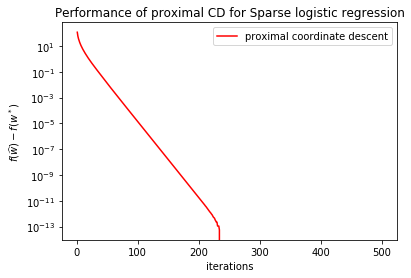

In [16]:
iter_range = np.arange(objs_cd_logreg.shape[0])+1
plt.semilogy(iter_range, objs_cd_logreg - objs_cd_logreg[-1], color='r', label='proximal coordinate descent')
plt.legend()
plt.ylabel('$f(\widehat{w}) - f(w^*)$')
plt.xlabel('iterations')
plt.title('Performance of proximal CD for Sparse logistic regression')

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [17]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [18]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

Let us first recall the LASSO problem:
$$
\min_w \left\{ \frac{1}{2} \Vert Xw - y\Vert_2^2 + \lambda \Vert w\Vert_1 \right\}.
$$

Then, a simple proximal gradient solver for the Lasso could be computed as:
$$w^{t+1} = \text{prox}_{\frac{\lambda}{L}\Vert w\Vert_1}\left(w^t - \frac{1}{L}X^T(Xw^t-y)\right),$$
where $\text{prox}_{\lambda\Vert w\Vert_1}(w) = \left(S_{\lambda}(w_1), \dots , S_{\lambda}(w_p)\right)$ with $S$ being the soft threshold function and $L=\sigma^2_{\max}(X)$.

In [19]:
def lasso_proxGD(X,y,lamb,n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    XTX = np.dot(X.T,X)
    XTy = np.dot(X.T,y)

    all_objs = np.empty(n_iter)
    
    lips_const = np.linalg.norm(X, ord=2) ** 2
    
    for t in range(n_iter):
        w = soft_thresh(w - 1./lips_const*(XTX.dot(w)-XTy), 
                        lamb/lips_const)
        
        all_objs[t] = 0.5 * np.linalg.norm(X.dot(w) - y) ** 2 + lamb * norm(w, ord=1)
    
    return w, all_objs

In [20]:
def lasso_proxCD(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    residuals = X.dot(w) - y

    all_objs = np.empty(n_iter)
    
    lips_const = np.sum(X ** 2, axis=0)
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            w[j] = soft_thresh(old_w_j - 1. / lips_const[j] * X[:,j].dot(residuals) ,
                               lamb / lips_const[j])
            
            if old_w_j != w[j]:
                residuals += ( - X[:,j].dot(old_w_j) + X[:,j].dot(w[j]) )
            
        all_objs[t] = (residuals ** 2).sum() / 2. + lamb * norm(w, ord=1)
    
    return w, all_objs

In [22]:
%time w_proxCD, objs_proxCD = lasso_proxCD(X,y,lambd,500)
print(objs_proxCD[-1])

CPU times: user 25.7 s, sys: 101 ms, total: 25.8 s
Wall time: 25.8 s
26.49967787413481


In [23]:
%time w_proxGD, objs_proxGD = lasso_proxGD(X,y,lambd,500)
print(objs_proxGD[-1])

CPU times: user 27 s, sys: 267 ms, total: 27.3 s
Wall time: 13.9 s
27.817813445952943


Text(0.5, 1.0, 'Comparision of objective function error for Lasso - prox GD and prox CD')

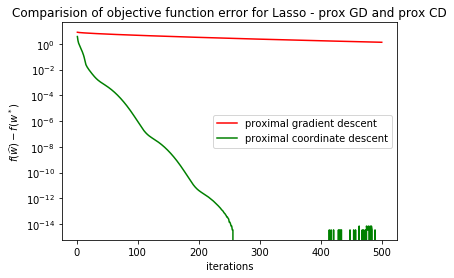

In [26]:
iter_range = np.arange(objs_proxGD.shape[0])+1
plt.semilogy(iter_range, objs_proxGD - objs_proxCD[-1], color='r', label='proximal gradient descent')
plt.semilogy(iter_range, objs_proxCD - objs_proxCD[-1], color='g', label='proximal coordinate descent')
plt.legend()
plt.ylabel('$f(\widehat{w}) - f(w^*)$')
plt.xlabel('iterations')
plt.title('Comparision of objective function error for Lasso - prox GD and prox CD')

### Coments 

We observe that the proximal CD performs a lot better than proximal GD for the Lasso problem. In fact, if we take the value returned by the prox CD method as the true minimum, we can see that the prox GD converges less quickly than the other method.